In [ ]:
import os
import requests
from tqdm import tqdm
import zipfile
from pandas import read_csv
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten
from keras.layers import Conv1D, MaxPooling1D
from sklearn.metrics import confusion_matrix
from keras.layers import Conv1D, Add, BatchNormalization, Activation, Input
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

print("####### LOCALIZATION")

def download_data():
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)


####### LOCALIZATION


In [ ]:
download_data()

In [ ]:
# Charger les données
file_data_train = "dataset/reduced_train.npz"
train = np.load(file_data_train)
X = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Encodage des labels
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

# Conversion des labels en one-hot encoding
onehot_Y = to_categorical(classes_Y)

# Fonction pour un bloc résiduel avec convolution 1x1 pour le chemin de raccourci
def residual_block(x, filters, kernel_size=3, stride=1):
    # Chemin d'origine (shortcut)
    shortcut = x

    # Chemin principal : deux convolutions
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adapter le chemin de raccourci si les dimensions ne correspondent pas
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    # Ajouter le chemin d'origine au chemin de convolution
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Définir l'architecture du modèle ResNet
input_shape = (400, 20)  # Adapter à la forme de tes données
inputs = Input(shape=input_shape)

# Première couche de convolution
x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Ajouter des blocs résiduels
x = residual_block(x, 64)  # Premier bloc avec 64 filtres
x = residual_block(x, 128)  # Deuxième bloc avec 128 filtres
x = residual_block(x, 256)  # Troisième bloc avec 256 filtres

# Aplatissement des caractéristiques pour la classification
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)  # 10 classes (adapter si nécessaire)

# Modèle complet
model = Model(inputs, outputs)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Diviser les données en ensembles d'entraînement et de test

X_train, X_test, y_train, y_test = train_test_split(X, onehot_Y, test_size=0.2, random_state=0)

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluation du modèle
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1] * 100))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 200, 64)        │          9,024 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 200, 64)        │            256 │ conv1d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 200, 64)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 200, 64)        │         12,352 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 200, 64)        │            256 │ conv1d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 200, 64)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 200, 64)        │         12,352 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 200, 64)        │            256 │ conv1d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 200, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 200, 64)        │              0 │ add_9[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 200, 128)       │         24,704 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 200, 128)       │            512 │ conv1d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22             │ (None, 200, 128)       │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)   

 Total params: 13,558,346 (51.72 MB)

 Trainable params: 13,556,426 (51.71 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 832ms/step - accuracy: 0.1966 - loss: 10.7348 - val_accuracy: 0.2191 - val_loss: 2.1715
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 873ms/step - accuracy: 0.3565 - loss: 1.8097 - val_accuracy: 0.1160 - val_loss: 2.2102
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 824ms/step - accuracy: 0.5495 - loss: 1.3248 - val_accuracy: 0.1160 - val_loss: 2.9648
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 47s 936ms/step - accuracy: 0.7376 - loss: 0.7510 - val_accuracy: 0.1160 - val_loss: 2.3316
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 78s 860ms/step - accuracy: 0.8284 - loss: 0.5484 - val_accuracy: 0.1289 - val_loss: 2.1200
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 805ms/step - accuracy: 0.8873 - loss: 0.3504 - val_accuracy: 0.3196 - val_loss: 1.9475
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 803ms/step - accuracy: 0.9202 - loss: 0.2786 - val_accuracy: 0.3454 - val_loss: 1.8280
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 811ms/step - accuracy: 0.9170 - loss: 0.2280 - val_acc

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


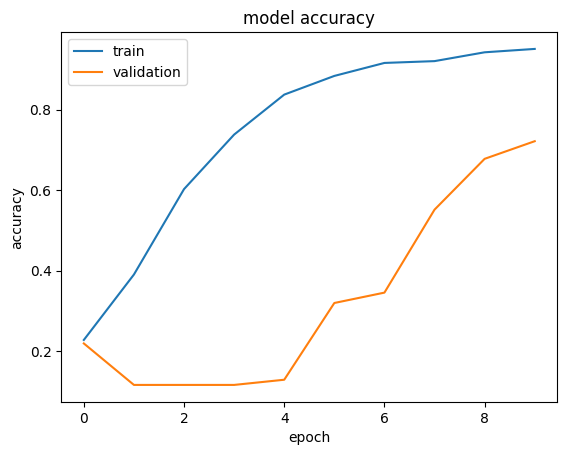

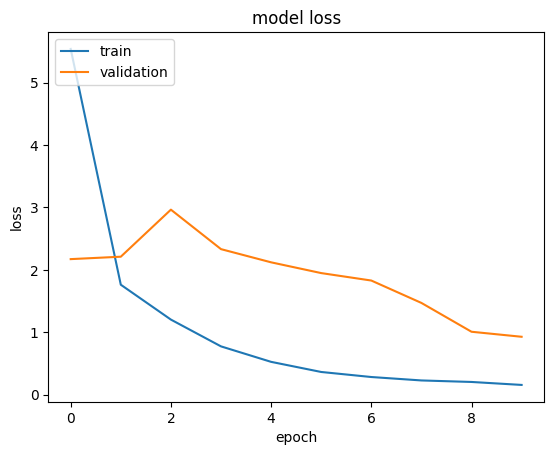

In [ ]:
# plot the history
#
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step


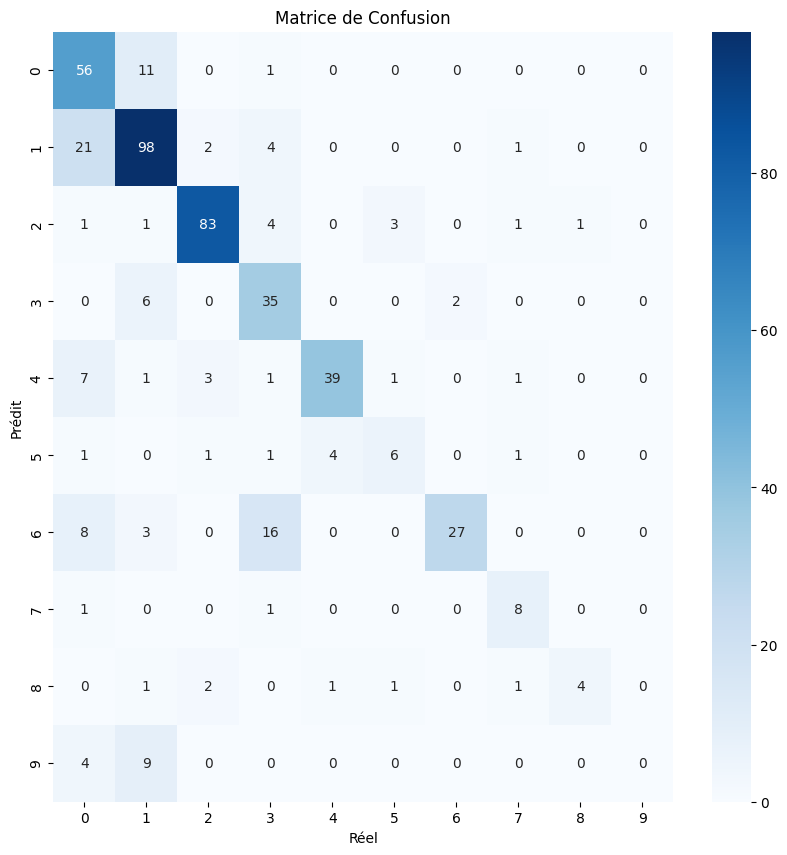

In [ ]:
predictions = model.predict(X_test)
pred_uni = np.argmax(predictions, axis=1)

# Convertir les étiquettes originales en labels pour la matrice de confusion
y_test_labels = np.argmax(y_test, axis=1)  # Récupérer les classes réelles

# Calculer la matrice de confusion
cm = confusion_matrix(y_test_labels, pred_uni)

# Tracer la matrice de confusion
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=classes.classes_, yticklabels=classes.classes_)
ax.set_xlabel("Réel")
ax.set_ylabel("Prédit")
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_matrix(train_labels, pred_uni, normalize="true"), annot=True)
ax.set(xlabel="reel", ylabel="predit")